In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [45]:
# load LEIE from efs
LEIE_df = pd.read_csv('~/SageMaker/efs/DrFraud/data/LEIE.csv', index_col=0)
LEIE_df.head()

,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,...,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE,year,month,key_present
0,NaN,NaN,,184TH STREET PHARMACY CORP,OTHER BUSINESS,PHARMACY,NaN,1922348218,NaN,69 E 184TH ST,...,NY,10468,1128a1,20180419,0,0,NaN,2018,4,True
1,NaN,NaN,,"A & Y MEDICAL SUPPLY, INC",DME COMPANY,DME - GENERAL,NaN,1942476080,NaN,"6310 108TH STREET, APT 6J",...,NY,11375,1128b8,20170518,0,0,NaN,2017,5,True
2,NaN,NaN,,"A FAIR DEAL PHARMACY, INC",OTHER BUSINESS,PHARMACY,NaN,1891731758,NaN,"C/O P O BOX 329014, #69709-05",...,NY,11232,1128b8,20170518,0,0,NaN,2017,5,True
3,NaN,NaN,,ACCELERATED BEHAVIOR MANAGEMEN,OTHER BUSINESS,COMM MNTL HLTH CNTR,NaN,1902198435,NaN,6148 W SAHARA AVENUE,...,NV,89146,1128a1,20160120,0,0,NaN,2016,1,True
4,NaN,NaN,,ADAMS LOVING PRO HEALTH CARE,OTHER BUSINESS,HOME HEALTH AGENCY,NaN,1073682936,NaN,"1277 HIGHWAY 82 W, STE 218",...,GA,31763,1128b7,20150409,0,0,NaN,2015,4,True


In [46]:
# load id_df from efs
id_df = pd.read_csv('~/SageMaker/efs/DrFraud/data/id_df.csv', index_col=0)
id_df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,year
0,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,ISOSORBIDE MONONITRATE ER,ISOSORBIDE MONONITRATE,NaN,...,307,171.59,NaN,*,NaN,*,NaN,NaN,NaN,2013
1,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,LEVOFLOXACIN,LEVOFLOXACIN,26.0,...,165,227.10,15.0,NaN,15.0,NaN,15.0,106.0,159.72,2013
2,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,LISINOPRIL,LISINOPRIL,17.0,...,570,100.37,NaN,#,NaN,#,NaN,NaN,NaN,2013
3,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,METOPROLOL TARTRATE,METOPROLOL TARTRATE,28.0,...,916,154.65,NaN,#,NaN,#,NaN,NaN,NaN,2013
4,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,PREDNISONE,PREDNISONE,14.0,...,133,44.72,NaN,*,NaN,*,NaN,NaN,NaN,2013


In [97]:
states = set(LEIE_df['STATE']).intersection(set(id_df['nppes_provider_state']))
id_df1 = id_df.where(id_df['nppes_provider_state'].isin(states))
LEIE_df1 = LEIE_df.where(LEIE_df['STATE'].isin(states))

In [98]:
# Find NPIs by state in part D
pard_D_count_df = id_df1.groupby('nppes_provider_state').agg('count').sort_values('npi', ascending=False)['npi']
pard_D_count_df.head()

nppes_provider_state
CA    2284050
NY    1627706
FL    1572285
TX    1437683
PA    1215298
Name: npi, dtype: int64

In [99]:
# Find NPIs by state in LEIE
LEIE_count_df = LEIE_df1.groupby('STATE').agg('count').sort_values('NPI', ascending=False)['NPI']
LEIE_count_df.head()

STATE
CA    415
NY    289
FL    209
TX    152
OH    140
Name: NPI, dtype: int64

In [100]:
state_count_df = pd.concat([LEIE_count_df, 
                            pard_D_count_df, 
                            LEIE_count_df/pard_D_count_df], axis=1)
state_count_df.rename(columns={'NPI':'LEIE', 'npi':'Part D', 0:'Ratio'}, inplace=True)
state_count_df.sort_values('Ratio', ascending=False, inplace=True)
state_count_df.head()

,LEIE,Part D,Ratio
NV,59,145182,0.000406
VI,1,2741,0.000365
AK,10,28451,0.000351
WV,66,204189,0.000323
UT,38,135550,0.000280


### Let's find out the most optimal threshold for of states to include
---

In [108]:
state_count_cumsum_df = state_count_df[['LEIE','Part D']].cumsum()
cum_ratio = state_count_df['LEIE']/state_count_df['Part D']
LEIE_proportion = state_count_cumsum_df['LEIE']/state_count_cumsum_df['LEIE'][-1]
partD_proportion = state_count_cumsum_df['Part D']/state_count_cumsum_df['Part D'][-1]
state_ratio_df = pd.concat([LEIE_proportion,
                            partD_proportion,
                            cum_ratio], axis=1)
state_ratio_df.rename(columns={'NPI':'LEIE', 'npi':'Part D', 0:'Ratio'}, inplace=True)


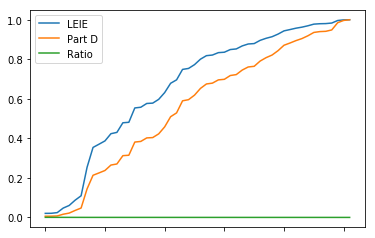

In [111]:
state_ratio_df.plot()
plt.show()

In [112]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

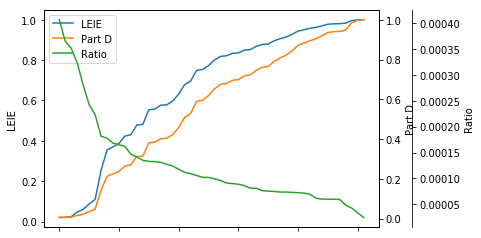

In [113]:
plt
plot_multi(state_ratio_df)
plt.show()